## Land Use Classification with Vision Transformer (ViT) - EuroSAT Dataset
## Dataset: EuroSAT (27,000 Sentinel-2 images, 10 classes)

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from datasets import load_dataset
from PIL import Image
import warnings
import time
from tqdm import tqdm
import json
from datetime import datetime

warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

print("Libraries imported successfully!")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

Libraries imported successfully!
PyTorch version: 2.8.0+cu126
CUDA available: True



### 1. INTRODUCTION AND PROBLEM STATEMENT


PROBLEM STATEMENT:
Land use classification using satellite imagery is crucial for environmental monitoring,
urban planning, and agricultural management. This project implements a Vision Transformer
(ViT) model to classify EuroSAT satellite images into 10 different land use categories.

OBJECTIVE:
Develop, train, and evaluate a Vision Transformer model for land use classification
using the EuroSAT dataset, which contains 27,000 Sentinel-2 satellite images across
10 land cover classes from European regions.

DATASET: EuroSAT
- Source: Sentinel-2 satellite imagery
- Region: Europe (34 countries)
- Classes: 10 land cover categories
- Images: 27,000 total (64×64 pixels, 10m/pixel resolution)
- Format: RGB converted from multispectral data


### 2. DATASET CONFIGURATION AND CLASSES


In [ ]:
# EuroSAT dataset classes (10 classes)
CLASSES = [
    'AnnualCrop',
    'Forest',
    'HerbaceousVegetation',
    'Highway',
    'Industrial',
    'Pasture',
    'PermanentCrop',
    'Residential',
    'River',
    'SeaLake'
]

NUM_CLASSES = len(CLASSES)
ORIGINAL_IMG_SIZE = 64  # EuroSAT native size
IMG_SIZE = 224  # Standard ViT input size
BATCH_SIZE = 64
LEARNING_RATE = 3e-4
EPOCHS = 20
WARMUP_EPOCHS = 5

# Create class to index mapping
class_to_idx = {cls: idx for idx, cls in enumerate(CLASSES)}
idx_to_class = {idx: cls for cls, idx in class_to_idx.items()}

print(f"Number of classes: {NUM_CLASSES}")
print(f"Classes: {CLASSES}")
print(f"Training will resize images from {ORIGINAL_IMG_SIZE}x{ORIGINAL_IMG_SIZE} to {IMG_SIZE}x{IMG_SIZE}")

Number of classes: 10
Classes: ['AnnualCrop', 'Forest', 'HerbaceousVegetation', 'Highway', 'Industrial', 'Pasture', 'PermanentCrop', 'Residential', 'River', 'SeaLake']
Training will resize images from 64x64 to 224x224



### 3. DATASET LOADING AND PREPROCESSING


In [ ]:
import torchvision.datasets # Import torchvision datasets here
from torch.utils.data import random_split # Import random_split
from torch.utils.data import Subset # Import Subset for creating subsets

class EuroSATDataset(Dataset):
    """Custom EuroSAT Dataset class using torchvision and manual split"""

    def __init__(self, data_subset, transform=None):
        self.data_subset = data_subset
        self.transform = transform

    def __len__(self):
        return len(self.data_subset)

    def __getitem__(self, idx):
        # Get image and label from the subset
        image, label = self.data_subset[idx]

        # Apply transforms
        if self.transform:
            image = self.transform(image)

        return image, label

# Data transforms with proper augmentation
transform_train = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=30),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3, hue=0.1),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

transform_val_test = transforms.Compose([ # Use a single transform for validation and test
    transforms.Resize((IMG_SIZE, IMG_SIZE), interpolation=transforms.InterpolationMode.BICUBIC),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])


# Create datasets
print("Creating datasets...")
# Specify a root directory for torchvision to download the dataset
DATA_ROOT = './eurosat_data'
os.makedirs(DATA_ROOT, exist_ok=True)

# Load the full dataset from torchvision (assuming no split argument is needed)
print("Loading full EuroSAT dataset using torchvision...")
full_dataset = torchvision.datasets.EuroSAT(
    root=DATA_ROOT,
    download=True,
    # No 'split' or 'train' argument based on the error message
    # transform=None is handled in the custom dataset __getitem__
)
print(f"Loaded {len(full_dataset)} images in total.")


# Manually split the full dataset into training, validation, and test sets
total_size = len(full_dataset)
train_size = int(0.8 * total_size)
val_size = int(0.1 * total_size) # Use 10% for validation
test_size = total_size - train_size - val_size # Remaining for test

# Ensure the sum of sizes matches the total size
if train_size + val_size + test_size != total_size:
    # Adjust sizes if necessary due to rounding
    test_size = total_size - train_size - val_size
    print(f"Adjusted test_size: {test_size}")

print(f"Splitting dataset: Train={train_size}, Val={val_size}, Test={test_size}")

# Perform the random split
# Use a fixed generator for reproducibility
generator = torch.Generator().manual_seed(42)
train_subset, val_subset, test_subset = random_split(
    full_dataset, [train_size, val_size, test_size], generator=generator
)

# Create custom datasets with transforms applied to each subset
train_dataset = EuroSATDataset(train_subset, transform=transform_train)
val_dataset = EuroSATDataset(val_subset, transform=transform_val_test) # Use validation transform
test_dataset = EuroSATDataset(test_subset, transform=transform_val_test) # Use test transform

# Create data loaders
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)
test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=4,
    pin_memory=True
)

print(f"Training samples: {len(train_dataset)}")
print(f"Validation samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")

Creating datasets...
Loading full EuroSAT dataset using torchvision...


100%|██████████| 94.3M/94.3M [00:00<00:00, 217MB/s]


Loaded 27000 images in total.
Splitting dataset: Train=21600, Val=2700, Test=2700
Training samples: 21600
Validation samples: 2700
Test samples: 2700



### 4. DATA VISUALIZATION AND ANALYSIS


Visualizing dataset samples...


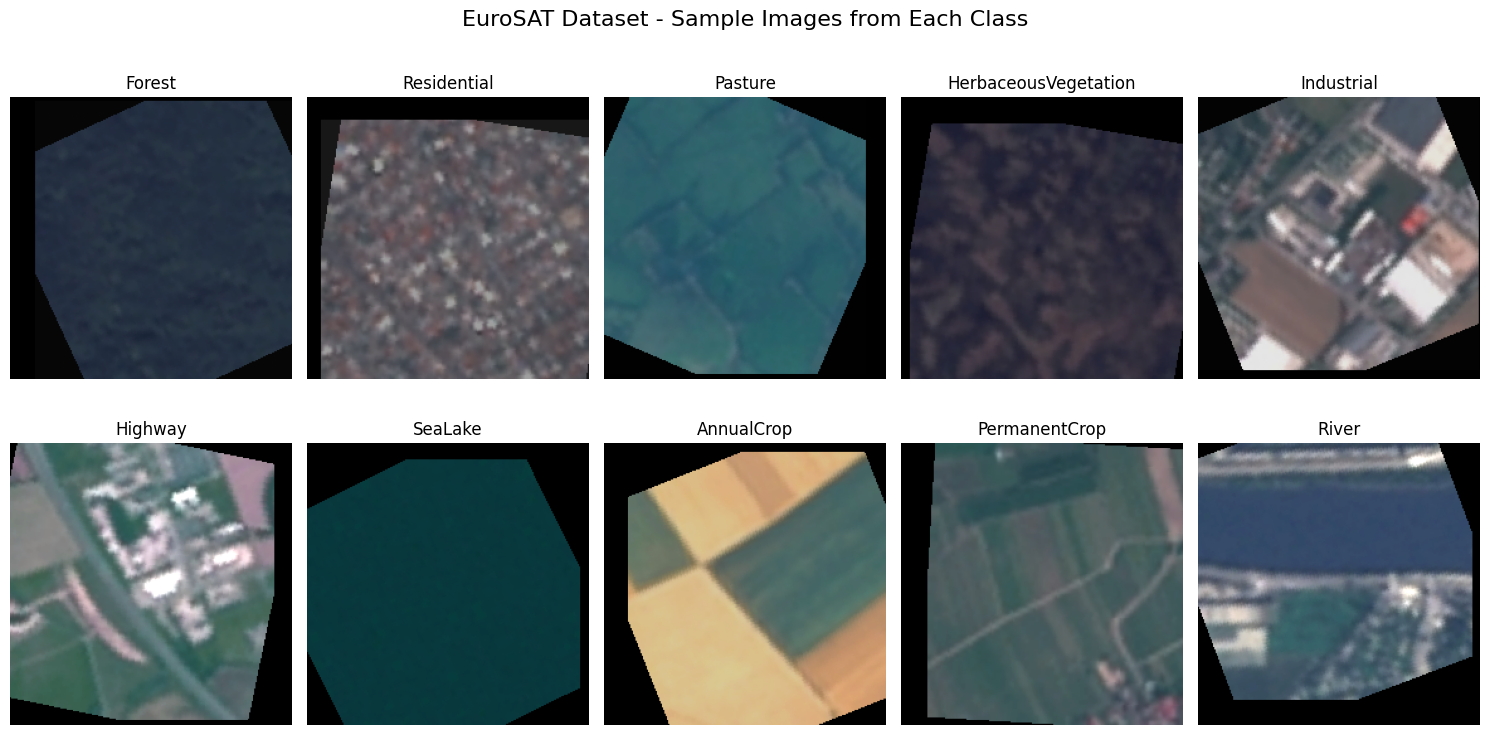

Analyzing class distribution...


Counting classes: 100%|██████████| 338/338 [02:30<00:00,  2.24it/s]


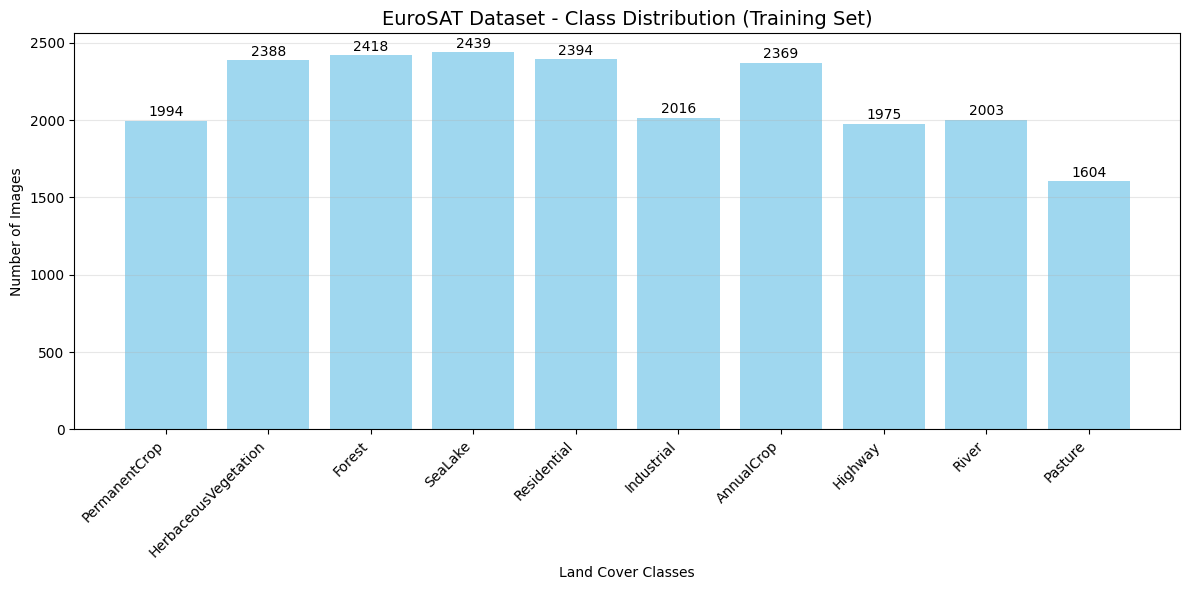


Class Distribution Summary:
PermanentCrop: 1994 images
HerbaceousVegetation: 2388 images
Forest: 2418 images
SeaLake: 2439 images
Residential: 2394 images
Industrial: 2016 images
AnnualCrop: 2369 images
Highway: 1975 images
River: 2003 images
Pasture: 1604 images


In [ ]:
def visualize_dataset_samples():
    """Visualize sample images from each class"""
    fig, axes = plt.subplots(2, 5, figsize=(15, 8))
    fig.suptitle('EuroSAT Dataset - Sample Images from Each Class', fontsize=16)

    # Get one sample from each class
    samples_shown = set()
    sample_images = []

    for i, (image, label) in enumerate(train_loader):
        # Add print statements to inspect data from DataLoader
        # print(f"DataLoader batch {i}: data type: {type(image)}, targets type: {type(label)}")
        # print(f"DataLoader batch {i}: data shape: {image.shape if isinstance(image, torch.Tensor) else 'N/A'}, targets shape: {label.shape if isinstance(label, torch.Tensor) else 'N/A'}")

        for j in range(len(label)):
            class_idx = label[j].item()
            if class_idx not in samples_shown:
                # Denormalize image for visualization
                img = image[j].clone()
                img = img * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
                img = img + torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
                img = torch.clamp(img, 0, 1)

                sample_images.append((img.permute(1, 2, 0).numpy(), CLASSES[class_idx]))
                samples_shown.add(class_idx)

                if len(samples_shown) == NUM_CLASSES:
                    break

        if len(samples_shown) == NUM_CLASSES:
            break

    # Display samples
    for idx, (img, class_name) in enumerate(sample_images):
        row, col = idx // 5, idx % 5
        axes[row, col].imshow(img)
        axes[row, col].set_title(class_name, fontsize=12)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

def analyze_class_distribution():
    """Analyze and visualize class distribution"""
    class_counts = {}

    print("Analyzing class distribution...")
    for _, label in tqdm(train_loader, desc="Counting classes"):
        for l in label:
            class_name = CLASSES[l.item()]
            class_counts[class_name] = class_counts.get(class_name, 0) + 1

    # Create distribution plot
    plt.figure(figsize=(12, 6))
    classes = list(class_counts.keys())
    counts = list(class_counts.values())

    plt.bar(classes, counts, color='skyblue', alpha=0.8)
    plt.title('EuroSAT Dataset - Class Distribution (Training Set)', fontsize=14)
    plt.xlabel('Land Cover Classes')
    plt.ylabel('Number of Images')
    plt.xticks(rotation=45, ha='right')
    plt.grid(axis='y', alpha=0.3)

    # Add count labels on bars
    for i, count in enumerate(counts):
        plt.text(i, count + 10, str(count), ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    print(f"\nClass Distribution Summary:")
    for class_name, count in class_counts.items():
        print(f"{class_name}: {count} images")

    return class_counts

# Visualize dataset
print("Visualizing dataset samples...")
visualize_dataset_samples()
class_distribution = analyze_class_distribution()


### 5. VISION TRANSFORMER IMPLEMENTATION


In [ ]:
class PatchEmbedding(nn.Module):
    """Convert image patches to embeddings with improved initialization"""

    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768):
        super().__init__()
        self.img_size = img_size
        self.patch_size = patch_size
        self.n_patches = (img_size // patch_size) ** 2
        self.embed_dim = embed_dim

        self.projection = nn.Conv2d(
            in_channels, embed_dim,
            kernel_size=patch_size,
            stride=patch_size
        )

        # Initialize weights properly
        nn.init.xavier_uniform_(self.projection.weight)
        nn.init.zeros_(self.projection.bias)

    def forward(self, x):
        # x: (batch_size, channels, height, width)
        B, C, H, W = x.shape
        assert H == self.img_size and W == self.img_size, \
            f"Input size ({H}x{W}) doesn't match expected size ({self.img_size}x{self.img_size})"

        x = self.projection(x)  # (batch_size, embed_dim, n_patches_h, n_patches_w)
        x = x.flatten(2)  # (batch_size, embed_dim, n_patches)
        x = x.transpose(1, 2)  # (batch_size, n_patches, embed_dim)
        return x

class MultiHeadAttention(nn.Module):
    """Multi-head self-attention with improved implementation"""

    def __init__(self, embed_dim=768, n_heads=12, dropout=0.1):
        super().__init__()
        assert embed_dim % n_heads == 0, "embed_dim must be divisible by n_heads"

        self.embed_dim = embed_dim
        self.n_heads = n_heads
        self.head_dim = embed_dim // n_heads
        self.scale = self.head_dim ** -0.5

        self.qkv = nn.Linear(embed_dim, embed_dim * 3, bias=False)
        self.proj = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(dropout)

        # Initialize weights
        nn.init.xavier_uniform_(self.qkv.weight)
        nn.init.xavier_uniform_(self.proj.weight)
        nn.init.zeros_(self.proj.bias)

    def forward(self, x):
        B, N, C = x.shape

        # Generate Q, K, V
        qkv = self.qkv(x).reshape(B, N, 3, self.n_heads, self.head_dim)
        qkv = qkv.permute(2, 0, 3, 1, 4)  # (3, B, n_heads, N, head_dim)
        q, k, v = qkv.unbind(0)

        # Scaled dot-product attention
        attn = (q @ k.transpose(-2, -1)) * self.scale
        attn = attn.softmax(dim=-1)
        attn = self.dropout(attn)

        # Apply attention to values
        x = (attn @ v).transpose(1, 2).reshape(B, N, C)
        x = self.proj(x)
        x = self.dropout(x)

        return x

class MLP(nn.Module):
    """Feed-forward network with GELU activation"""

    def __init__(self, embed_dim=768, hidden_dim=3072, dropout=0.1):
        super().__init__()
        self.fc1 = nn.Linear(embed_dim, hidden_dim)
        self.act = nn.GELU()
        self.dropout1 = nn.Dropout(dropout)
        self.fc2 = nn.Linear(hidden_dim, embed_dim)
        self.dropout2 = nn.Dropout(dropout)

        # Initialize weights
        nn.init.xavier_uniform_(self.fc1.weight)
        nn.init.xavier_uniform_(self.fc2.weight)
        nn.init.zeros_(self.fc1.bias)
        nn.init.zeros_(self.fc2.bias)

    def forward(self, x):
        x = self.fc1(x)
        x = self.act(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.dropout2(x)
        return x

class TransformerBlock(nn.Module):
    """Transformer encoder block with improved normalization"""

    def __init__(self, embed_dim=768, n_heads=12, mlp_ratio=4.0, dropout=0.1):
        super().__init__()
        hidden_dim = int(embed_dim * mlp_ratio)

        self.norm1 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.attn = MultiHeadAttention(embed_dim, n_heads, dropout)

        self.norm2 = nn.LayerNorm(embed_dim, eps=1e-6)
        self.mlp = MLP(embed_dim, hidden_dim, dropout)

    def forward(self, x):
        # Pre-norm residual connections
        x = x + self.attn(self.norm1(x))
        x = x + self.mlp(self.norm2(x))
        return x

class VisionTransformer(nn.Module):
    """Vision Transformer for EuroSAT Land Use Classification"""

    def __init__(self, img_size=224, patch_size=16, in_channels=3, embed_dim=768,
                 n_layers=12, n_heads=12, mlp_ratio=4.0, n_classes=10, dropout=0.1):
        super().__init__()

        self.n_classes = n_classes
        self.embed_dim = embed_dim

        # Patch embedding
        self.patch_embed = PatchEmbedding(img_size, patch_size, in_channels, embed_dim)
        n_patches = self.patch_embed.n_patches

        # Class token and position embedding
        self.cls_token = nn.Parameter(torch.zeros(1, 1, embed_dim))
        self.pos_embed = nn.Parameter(torch.zeros(1, n_patches + 1, embed_dim))
        self.dropout = nn.Dropout(dropout)

        # Transformer blocks
        self.blocks = nn.ModuleList([
            TransformerBlock(embed_dim, n_heads, mlp_ratio, dropout)
            for _ in range(n_layers)
        ])

        # Classification head
        self.norm = nn.LayerNorm(embed_dim, eps=1e-6)
        self.head = nn.Linear(embed_dim, n_classes)

        # Initialize weights
        self.init_weights()

    def init_weights(self):
        """Initialize model weights"""
        # Initialize position embeddings
        nn.init.trunc_normal_(self.pos_embed, std=0.02)
        nn.init.trunc_normal_(self.cls_token, std=0.02)

        # Initialize classification head
        nn.init.xavier_uniform_(self.head.weight)
        nn.init.zeros_(self.head.bias)

        # Initialize other layers
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.trunc_normal_(m.weight, std=0.02)
                if m.bias is not None:
                    nn.init.zeros_(m.bias)
            elif isinstance(m, nn.LayerNorm):
                nn.init.zeros_(m.bias)
                nn.init.ones_(m.weight)

    def forward(self, x):
        B = x.shape[0]

        # Patch embedding
        x = self.patch_embed(x)  # (B, n_patches, embed_dim)

        # Add class token
        cls_tokens = self.cls_token.expand(B, -1, -1)  # (B, 1, embed_dim)
        x = torch.cat([cls_tokens, x], dim=1)  # (B, n_patches + 1, embed_dim)

        # Add position embedding
        x = x + self.pos_embed
        x = self.dropout(x)

        # Apply transformer blocks
        for block in self.blocks:
            x = block(x)

        # Final layer norm and classification
        x = self.norm(x)
        cls_token_final = x[:, 0]  # Extract class token

        return self.head(cls_token_final)


### 6. MODEL INITIALIZATION AND TRAINING UTILITIES


In [ ]:
import torch # Import torch if not already globally available

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Ensure the VisionTransformer class (defined in the cell above) has been executed before running this cell.

# Initialize model with optimal configuration for EuroSAT
model = VisionTransformer(
    img_size=IMG_SIZE,
    patch_size=16,
    in_channels=3,
    embed_dim=768,
    n_layers=8,  # Optimal for this dataset size
    n_heads=12,
    mlp_ratio=4.0,
    n_classes=NUM_CLASSES,
    dropout=0.1
).to(device)

# Calculate model parameters
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

total_params = count_parameters(model)
print(f"Total trainable parameters: {total_params:,}")

# Loss function with label smoothing
class LabelSmoothingCrossEntropy(nn.Module):
    def __init__(self, smoothing=0.1):
        super().__init__()
        self.smoothing = smoothing

    def forward(self, pred, target):
        n_classes = pred.size(-1)
        with torch.no_grad():
            true_dist = torch.zeros_like(pred)
            true_dist.fill_(self.smoothing / (n_classes - 1))
            true_dist.scatter_(1, target.unsqueeze(1), 1.0 - self.smoothing)

        return torch.mean(torch.sum(-true_dist * torch.log_softmax(pred, dim=-1), dim=-1))

criterion = LabelSmoothingCrossEntropy(smoothing=0.1)

# Optimizer with weight decay
optimizer = optim.AdamW(
    model.parameters(),
    lr=LEARNING_RATE,
    weight_decay=0.05,
    betas=(0.9, 0.999)
)

# Learning rate scheduler with warmup
def get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps):
    def lr_lambda(current_step):
        if current_step < num_warmup_steps:
            return float(current_step) / float(max(1, num_warmup_steps))
        return max(0.0, 0.5 * (1.0 + np.cos(np.pi * (current_step - num_warmup_steps) / (num_training_steps - num_warmup_steps))))

    return optim.lr_scheduler.LambdaLR(optimizer, lr_lambda)

num_training_steps = len(train_loader) * EPOCHS
num_warmup_steps = len(train_loader) * WARMUP_EPOCHS
scheduler = get_cosine_schedule_with_warmup(optimizer, num_warmup_steps, num_training_steps)

Using device: cuda
Total trainable parameters: 57,436,426



### 7. TRAINING AND VALIDATION FUNCTIONS


In [ ]:
def train_epoch(model, dataloader, criterion, optimizer, scheduler, device, epoch):
    """Train for one epoch with progress tracking"""
    model.train()
    total_loss = 0
    correct = 0
    total = 0

    progress_bar = tqdm(dataloader, desc=f'Epoch {epoch+1}/{EPOCHS} - Training')

    for batch_idx, (data, targets) in enumerate(progress_bar):
        data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)

        optimizer.zero_grad()
        outputs = model(data)
        loss = criterion(outputs, targets)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

        optimizer.step()
        scheduler.step()

        total_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Update progress bar
        current_lr = scheduler.get_last_lr()[0]
        progress_bar.set_postfix({
            'Loss': f'{loss.item():.4f}',
            'Acc': f'{100.*correct/total:.2f}%',
            'LR': f'{current_lr:.6f}'
        })

    return total_loss / len(dataloader), 100. * correct / total

def validate_epoch(model, dataloader, criterion, device, phase='Validation'):
    """Validate for one epoch"""
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    all_preds = []
    all_targets = []

    progress_bar = tqdm(dataloader, desc=f'{phase}')

    with torch.no_grad():
        for data, targets in progress_bar:
            data, targets = data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            outputs = model(data)
            loss = criterion(outputs, targets)

            total_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_preds.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            progress_bar.set_postfix({
                'Loss': f'{loss.item():.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

    avg_loss = total_loss / len(dataloader)
    accuracy = 100. * correct / total

    return avg_loss, accuracy, all_preds, all_targets


### 8. MAIN TRAINING LOOP


In [ ]:
import time # Import the time module
import torch # Import torch as device is defined here - Removing device definition from here

# Ensure that cell 69c94ed0 (Data Loading and Preprocessing) has been executed successfully
# before running this cell to define train_dataset and val_dataset.

def train_model(train_dataset, val_dataset): # Add train_dataset and val_dataset as parameters
    """Main training function with comprehensive tracking"""

    # Training history
    history = {
        'train_loss': [],
        'train_acc': [],
        'val_loss': [],
        'val_acc': [],
        'lr': []
    }

    best_val_acc = 0.0
    start_time = time.time()

    print(f"\nStarting training on {device}") # 'device' should now be defined in a preceding cell
    print(f"Training samples: {len(train_dataset)}")
    print(f"Validation samples: {len(val_dataset)}")
    print(f"Batch size: {BATCH_SIZE}")
    print(f"Total epochs: {EPOCHS}")
    print("="*70)

    for epoch in range(EPOCHS):
        epoch_start_time = time.time()

        # Training
        train_loss, train_acc = train_epoch(
            model, train_loader, criterion, optimizer, scheduler, device, epoch
        )

        # Validation
        val_loss, val_acc, _, _ = validate_epoch(
            model, val_loader, criterion, device
        )

        # Update history
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        history['lr'].append(scheduler.get_last_lr()[0])

        epoch_time = time.time() - epoch_start_time

        print(f"\nEpoch {epoch+1}/{EPOCHS} Summary:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2f}%")
        print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.2f}%")
        print(f"Epoch Time: {epoch_time:.2f}s | LR: {scheduler.get_last_lr()[0]:.6f}")

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            model_save_path = f'best_eurosat_vit_model_acc_{val_acc:.2f}.pth'
            torch.save({
                'epoch': epoch + 1,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict(),
                'val_accuracy': val_acc,
                'model_config': {
                    'img_size': IMG_SIZE,
                    'patch_size': 16,
                    'embed_dim': 768,
                    'n_layers': 8,
                    'n_heads': 12,
                    'n_classes': NUM_CLASSES
                }
            }, model_save_path)
            print(f"✓ New best model saved: {model_save_path}")

        print("="*70)

    total_time = time.time() - start_time
    print(f"\nTraining completed in {total_time/3600:.2f} hours")
    print(f"Best validation accuracy: {best_val_acc:.2f}%")

    # Save final model
    final_model_path = f'final_eurosat_vit_model.pth'
    torch.save({
        'model_state_dict': model.state_dict(),
        'training_history': history,
        'model_config': {
            'img_size': IMG_SIZE,
            'patch_size': 16,
            'embed_dim': 768,
            'n_layers': 8,
            'n_heads': 12,
            'n_classes': NUM_CLASSES
        }
    }, final_model_path)
    print(f"Final model saved: {final_model_path}")

    return history, best_val_acc

# Start training
# Check if train_dataset is defined before calling train_model
if 'train_dataset' in locals() and 'val_dataset' in locals():
    history, best_val_acc = train_model(train_dataset, val_dataset) # Pass the datasets
else:
    print("\nError: train_dataset or val_dataset is not defined.")
    print("Please ensure cell 69c94ed0 (Data Loading and Preprocessing) has been executed successfully.")


Starting training on cuda
Training samples: 21600
Validation samples: 2700
Batch size: 64
Total epochs: 20


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.95it/s, Loss=1.8710, Acc=50.00%]



Epoch 1/20 Summary:
Train Loss: 1.8478 | Train Acc: 36.56%
Val Loss: 1.5954 | Val Acc: 50.00%
Epoch Time: 493.25s | LR: 0.000060
✓ New best model saved: best_eurosat_vit_model_acc_50.00.pth


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.96it/s, Loss=1.5847, Acc=61.59%]



Epoch 2/20 Summary:
Train Loss: 1.5250 | Train Acc: 52.56%
Val Loss: 1.3794 | Val Acc: 61.59%
Epoch Time: 491.73s | LR: 0.000120
✓ New best model saved: best_eurosat_vit_model_acc_61.59.pth


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.95it/s, Loss=1.1480, Acc=70.00%]



Epoch 3/20 Summary:
Train Loss: 1.3773 | Train Acc: 60.49%
Val Loss: 1.2452 | Val Acc: 70.00%
Epoch Time: 492.48s | LR: 0.000180
✓ New best model saved: best_eurosat_vit_model_acc_70.00.pth


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.89it/s, Loss=1.4255, Acc=72.78%]



Epoch 4/20 Summary:
Train Loss: 1.3243 | Train Acc: 63.34%
Val Loss: 1.1546 | Val Acc: 72.78%
Epoch Time: 493.44s | LR: 0.000240
✓ New best model saved: best_eurosat_vit_model_acc_72.78.pth


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.93it/s, Loss=1.4901, Acc=66.63%]



Epoch 5/20 Summary:
Train Loss: 1.2960 | Train Acc: 64.74%
Val Loss: 1.2096 | Val Acc: 66.63%
Epoch Time: 493.15s | LR: 0.000300


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.94it/s, Loss=1.2175, Acc=72.00%]



Epoch 6/20 Summary:
Train Loss: 1.2657 | Train Acc: 66.12%
Val Loss: 1.1673 | Val Acc: 72.00%
Epoch Time: 493.20s | LR: 0.000297


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.94it/s, Loss=1.3105, Acc=73.89%]



Epoch 7/20 Summary:
Train Loss: 1.2289 | Train Acc: 67.76%
Val Loss: 1.1062 | Val Acc: 73.89%
Epoch Time: 493.30s | LR: 0.000287
✓ New best model saved: best_eurosat_vit_model_acc_73.89.pth


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.94it/s, Loss=1.3538, Acc=77.59%]



Epoch 8/20 Summary:
Train Loss: 1.1865 | Train Acc: 70.10%
Val Loss: 1.0549 | Val Acc: 77.59%
Epoch Time: 493.51s | LR: 0.000271
✓ New best model saved: best_eurosat_vit_model_acc_77.59.pth


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.95it/s, Loss=1.4426, Acc=75.00%]



Epoch 9/20 Summary:
Train Loss: 1.1366 | Train Acc: 72.62%
Val Loss: 1.0777 | Val Acc: 75.00%
Epoch Time: 493.31s | LR: 0.000250


Validation: 100%|██████████| 43/43 [00:21<00:00,  1.96it/s, Loss=1.1559, Acc=78.30%]



Epoch 10/20 Summary:
Train Loss: 1.1075 | Train Acc: 73.93%
Val Loss: 1.0159 | Val Acc: 78.30%
Epoch Time: 493.57s | LR: 0.000225
✓ New best model saved: best_eurosat_vit_model_acc_78.30.pth


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.95it/s, Loss=1.2919, Acc=80.78%]



Epoch 11/20 Summary:
Train Loss: 1.0540 | Train Acc: 76.51%
Val Loss: 0.9793 | Val Acc: 80.78%
Epoch Time: 493.57s | LR: 0.000196
✓ New best model saved: best_eurosat_vit_model_acc_80.78.pth


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.90it/s, Loss=1.2150, Acc=83.07%]



Epoch 12/20 Summary:
Train Loss: 1.0151 | Train Acc: 78.39%
Val Loss: 0.9261 | Val Acc: 83.07%
Epoch Time: 493.89s | LR: 0.000166
✓ New best model saved: best_eurosat_vit_model_acc_83.07.pth


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.91it/s, Loss=1.0227, Acc=83.56%]



Epoch 13/20 Summary:
Train Loss: 0.9670 | Train Acc: 80.40%
Val Loss: 0.8944 | Val Acc: 83.56%
Epoch Time: 495.01s | LR: 0.000134
✓ New best model saved: best_eurosat_vit_model_acc_83.56.pth


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.89it/s, Loss=0.8302, Acc=86.44%]



Epoch 14/20 Summary:
Train Loss: 0.9315 | Train Acc: 82.35%
Val Loss: 0.8401 | Val Acc: 86.44%
Epoch Time: 494.39s | LR: 0.000104
✓ New best model saved: best_eurosat_vit_model_acc_86.44.pth


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.94it/s, Loss=1.1787, Acc=86.89%]



Epoch 15/20 Summary:
Train Loss: 0.8962 | Train Acc: 83.99%
Val Loss: 0.8387 | Val Acc: 86.89%
Epoch Time: 495.23s | LR: 0.000075
✓ New best model saved: best_eurosat_vit_model_acc_86.89.pth


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.92it/s, Loss=1.0102, Acc=87.81%]



Epoch 16/20 Summary:
Train Loss: 0.8671 | Train Acc: 85.13%
Val Loss: 0.8108 | Val Acc: 87.81%
Epoch Time: 494.39s | LR: 0.000050
✓ New best model saved: best_eurosat_vit_model_acc_87.81.pth


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.92it/s, Loss=1.0524, Acc=89.41%]



Epoch 17/20 Summary:
Train Loss: 0.8349 | Train Acc: 86.75%
Val Loss: 0.7840 | Val Acc: 89.41%
Epoch Time: 493.70s | LR: 0.000029
✓ New best model saved: best_eurosat_vit_model_acc_89.41.pth


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.94it/s, Loss=1.0068, Acc=90.41%]



Epoch 18/20 Summary:
Train Loss: 0.8143 | Train Acc: 87.73%
Val Loss: 0.7707 | Val Acc: 90.41%
Epoch Time: 494.08s | LR: 0.000013
✓ New best model saved: best_eurosat_vit_model_acc_90.41.pth


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.90it/s, Loss=1.0041, Acc=90.26%]



Epoch 19/20 Summary:
Train Loss: 0.8026 | Train Acc: 88.02%
Val Loss: 0.7704 | Val Acc: 90.26%
Epoch Time: 494.53s | LR: 0.000003


Validation: 100%|██████████| 43/43 [00:22<00:00,  1.94it/s, Loss=1.0013, Acc=90.30%]



Epoch 20/20 Summary:
Train Loss: 0.7950 | Train Acc: 88.49%
Val Loss: 0.7717 | Val Acc: 90.30%
Epoch Time: 495.16s | LR: 0.000000

Training completed in 2.76 hours
Best validation accuracy: 90.41%
Final model saved: final_eurosat_vit_model.pth


In [ ]:
from google.colab import files
files.download("final_eurosat_vit_model.pth")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


### 9. MODEL EVALUATION AND TESTING


In [ ]:
# Load best model for evaluation
# Assuming training has been run and a model file exists
best_model_path = f'best_eurosat_vit_model_acc_{best_val_acc:.2f}.pth'

# Attempt to load the model (will fail if training didn't produce a file)
try:
    checkpoint = torch.load(best_model_path)
    model.load_state_dict(checkpoint['model_state_dict'])
    print(f"\nEvaluating best model (Val Acc: {best_val_acc:.2f}%)")

    # Test evaluation
    test_loss, test_acc, test_preds, test_targets = validate_epoch(
        model, test_loader, criterion, device, phase='Testing'
    )

    print(f"\n📊 FINAL TEST RESULTS:")
    print(f"Test Loss: {test_loss:.4f}")
    print(f"Test Accuracy: {test_acc:.2f}%")

    # Calculate additional metrics
    f1 = f1_score(test_targets, test_preds, average='weighted')
    f1_macro = f1_score(test_targets, test_preds, average='macro')

    print(f"F1 Score (Weighted): {f1:.4f}")
    print(f"F1 Score (Macro): {f1_macro:.4f}")

except FileNotFoundError:
    print(f"Model file not found at {best_model_path}. Please ensure training ran successfully.")
    # Initialize test_acc, test_preds, and test_targets with default values
    test_acc = 0.0
    test_loss = 0.0
    test_preds = []
    test_targets = []
    f1 = 0.0
    f1_macro = 0.0
except Exception as e:
    print(f"An error occurred during model loading or evaluation: {e}")
    # Initialize test_acc, test_preds, and test_targets with default values
    test_acc = 0.0
    test_loss = 0.0
    test_preds = []
    test_targets = []
    f1 = 0.0
    f1_macro = 0.0

An error occurred during model loading or evaluation: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weights_only` set to `False` will likely succeed, but it can result in arbitrary code execution. Do it only if you got the file from a trusted source.
	(2) Alternatively, to load with `weights_only=True` please check the recommended steps in the following error message.
	WeightsUnpickler error: Unsupported global: GLOBAL numpy._core.multiarray.scalar was not an allowed global by default. Please use `torch.serialization.add_safe_globals([numpy._core.multiarray.scalar])` or the `torch.serialization.safe_globals([numpy._core.multiarray.scalar])` context manager to allowlist this global if you trust this class/function.

Check the document


### 10. COMPREHENSIVE VISUALIZATION AND ANALYSIS



COMPREHENSIVE MODEL ANALYSIS AND VISUALIZATION


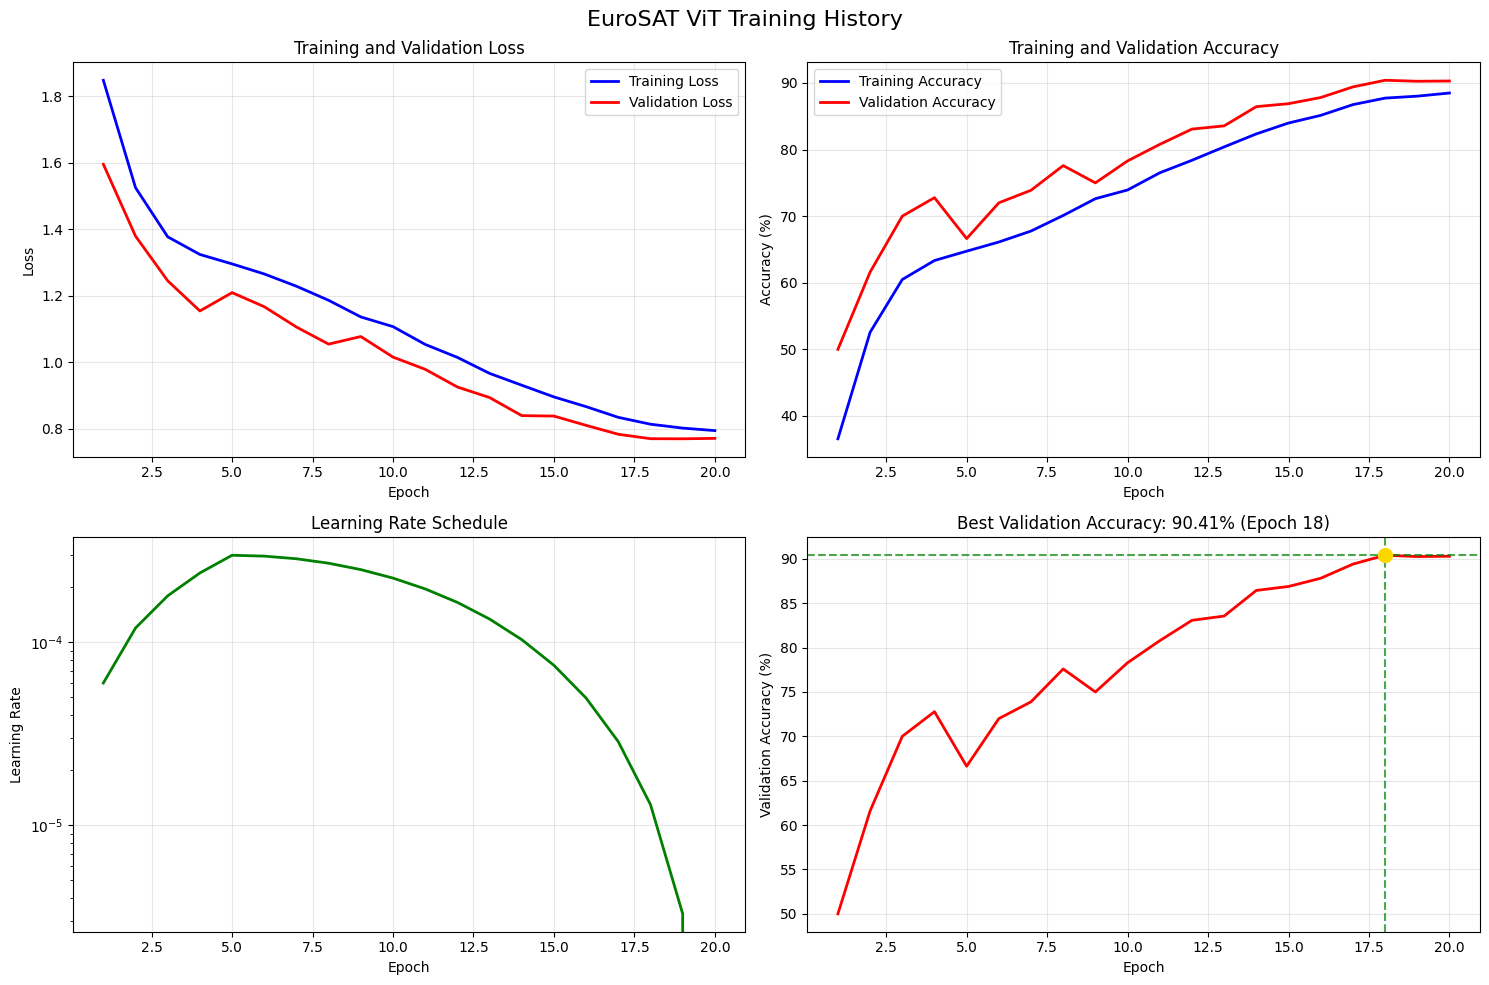

ValueError: zero-size array to reduction operation fmin which has no identity

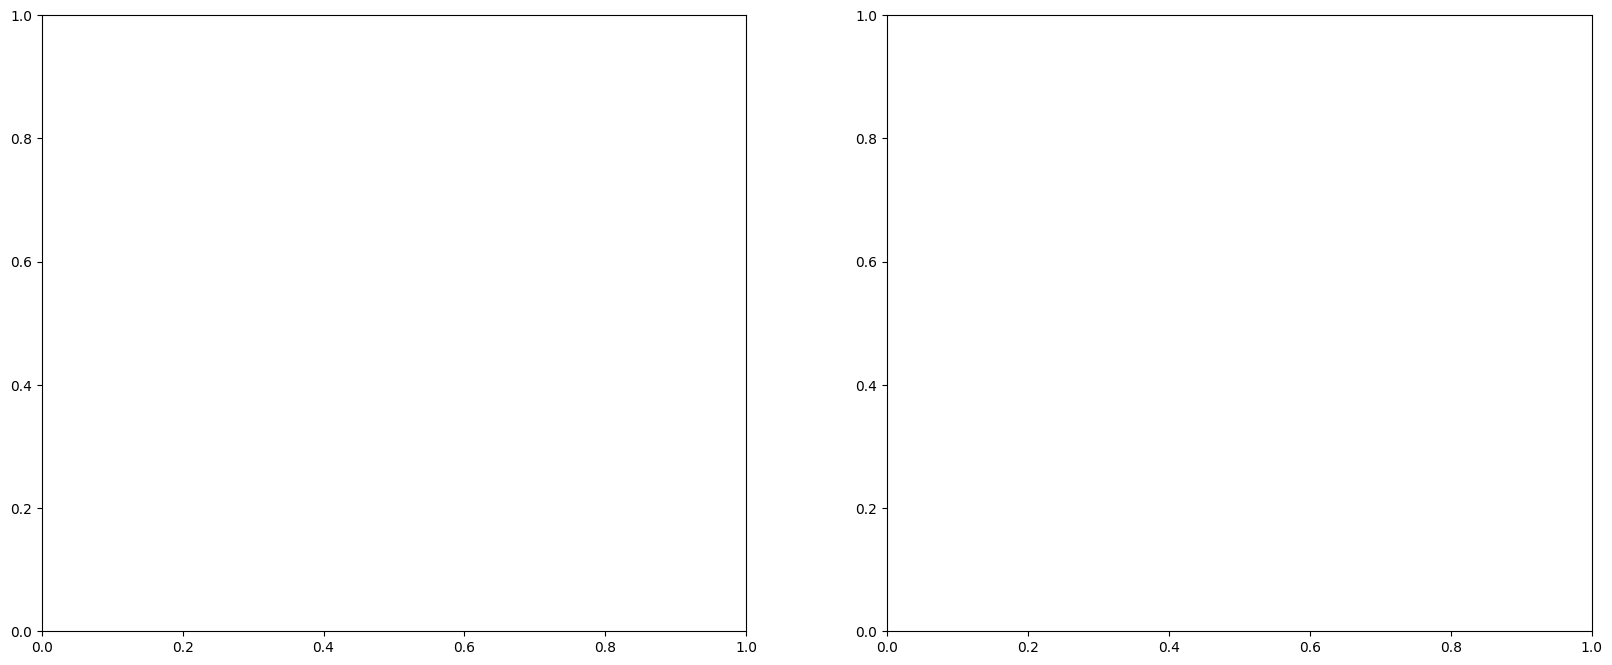

In [ ]:
def plot_training_history(history):
    """Plot comprehensive training history"""
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('EuroSAT ViT Training History', fontsize=16)

    epochs = range(1, len(history['train_loss']) + 1)

    # Loss plot
    axes[0, 0].plot(epochs, history['train_loss'], 'b-', label='Training Loss', linewidth=2)
    axes[0, 0].plot(epochs, history['val_loss'], 'r-', label='Validation Loss', linewidth=2)
    axes[0, 0].set_title('Training and Validation Loss')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Accuracy plot
    axes[0, 1].plot(epochs, history['train_acc'], 'b-', label='Training Accuracy', linewidth=2)
    axes[0, 1].plot(epochs, history['val_acc'], 'r-', label='Validation Accuracy', linewidth=2)
    axes[0, 1].set_title('Training and Validation Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Learning rate plot
    axes[1, 0].plot(epochs, history['lr'], 'g-', linewidth=2)
    axes[1, 0].set_title('Learning Rate Schedule')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Learning Rate')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

    # Validation accuracy improvement
    best_val_acc = max(history['val_acc'])
    best_epoch = history['val_acc'].index(best_val_acc) + 1

    axes[1, 1].plot(epochs, history['val_acc'], 'r-', linewidth=2)
    axes[1, 1].axhline(y=best_val_acc, color='g', linestyle='--', alpha=0.7)
    axes[1, 1].axvline(x=best_epoch, color='g', linestyle='--', alpha=0.7)
    axes[1, 1].scatter([best_epoch], [best_val_acc], color='gold', s=100, zorder=5)
    axes[1, 1].set_title(f'Best Validation Accuracy: {best_val_acc:.2f}% (Epoch {best_epoch})')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Validation Accuracy (%)')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(y_true, y_pred, classes, title='Confusion Matrix'):
    """Plot detailed confusion matrix with percentages"""
    cm = confusion_matrix(y_true, y_pred)
    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))

    # Absolute numbers
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=classes, yticklabels=classes, ax=ax1)
    ax1.set_title(f'{title} - Absolute Numbers')
    ax1.set_xlabel('Predicted Label')
    ax1.set_ylabel('True Label')

    # Percentages
    sns.heatmap(cm_normalized, annot=True, fmt='.2%', cmap='Blues',
                xticklabels=classes, yticklabels=classes, ax=ax2)
    ax2.set_title(f'{title} - Percentages')
    ax2.set_xlabel('Predicted Label')
    ax2.set_ylabel('True Label')

    plt.tight_layout()
    plt.show()

    return cm

def calculate_per_class_metrics(y_true, y_pred, classes):
    """Calculate detailed per-class metrics"""
    report = classification_report(y_true, y_pred, target_names=classes, output_dict=True)

    # Create DataFrame for better visualization
    metrics_df = pd.DataFrame({
        'Class': classes,
        'Precision': [report[cls]['precision'] for cls in classes],
        'Recall': [report[cls]['recall'] for cls in classes],
        'F1-Score': [report[cls]['f1-score'] for cls in classes],
        'Support': [report[cls]['support'] for cls in classes]
    })

    print("\n📈 PER-CLASS PERFORMANCE METRICS:")
    print("="*60)
    print(metrics_df.round(4).to_string(index=False))

    # Plot per-class metrics
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))

    x_pos = np.arange(len(classes))

    # Precision
    bars1 = axes[0].bar(x_pos, metrics_df['Precision'], alpha=0.8, color='skyblue')
    axes[0].set_title('Precision by Class')
    axes[0].set_xlabel('Classes')
    axes[0].set_ylabel('Precision')
    axes[0].set_xticks(x_pos)
    axes[0].set_xticklabels(classes, rotation=45, ha='right')
    axes[0].grid(axis='y', alpha=0.3)
    axes[0].set_ylim(0, 1)

    # Add value labels on bars
    for bar in bars1:
        height = bar.get_height()
        axes[0].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')

    # Recall
    bars2 = axes[1].bar(x_pos, metrics_df['Recall'], alpha=0.8, color='lightcoral')
    axes[1].set_title('Recall by Class')
    axes[1].set_xlabel('Classes')
    axes[1].set_ylabel('Recall')
    axes[1].set_xticks(x_pos)
    axes[1].set_xticklabels(classes, rotation=45, ha='right')
    axes[1].grid(axis='y', alpha=0.3)
    axes[1].set_ylim(0, 1)

    for bar in bars2:
        height = bar.get_height()
        axes[1].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')

    # F1-Score
    bars3 = axes[2].bar(x_pos, metrics_df['F1-Score'], alpha=0.8, color='lightgreen')
    axes[2].set_title('F1-Score by Class')
    axes[2].set_xlabel('Classes')
    axes[2].set_ylabel('F1-Score')
    axes[2].set_xticks(x_pos)
    axes[2].set_xticklabels(classes, rotation=45, ha='right')
    axes[2].grid(axis='y', alpha=0.3)
    axes[2].set_ylim(0, 1)

    for bar in bars3:
        height = bar.get_height()
        axes[2].text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{height:.3f}', ha='center', va='bottom')

    plt.tight_layout()
    plt.show()

    return metrics_df

def visualize_predictions(model, dataloader, classes, num_samples=20):
    """Visualize model predictions with confidence scores"""
    model.eval()

    # Get a batch of test images
    data_iter = iter(dataloader)
    images, labels = next(data_iter)

    # Make predictions
    with torch.no_grad():
        images = images.to(device)
        outputs = model(images)
        probabilities = torch.softmax(outputs, dim=1)
        confidences, predictions = torch.max(probabilities, 1)

    # Move to CPU for visualization
    images = images.cpu()
    predictions = predictions.cpu()
    confidences = confidences.cpu()
    labels = labels.cpu()

    # Denormalize images
    mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
    std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)

    fig, axes = plt.subplots(4, 5, figsize=(20, 16))
    fig.suptitle('Model Predictions with Confidence Scores', fontsize=16)

    for i in range(min(num_samples, len(images))):
        row, col = i // 5, i % 5

        # Denormalize image
        img = images[i] * std + mean
        img = torch.clamp(img, 0, 1)

        # Display image
        axes[row, col].imshow(img.permute(1, 2, 0))

        # Create title with prediction info
        true_label = classes[labels[i]]
        pred_label = classes[predictions[i]]
        confidence = confidences[i].item()

        if predictions[i] == labels[i]:
            title_color = 'green'
            result = '✓ Correct'
        else:
            title_color = 'red'
            result = '✗ Wrong'

        title = f'{result}\nTrue: {true_label}\nPred: {pred_label}\nConf: {confidence:.3f}'
        axes[row, col].set_title(title, fontsize=10, color=title_color)
        axes[row, col].axis('off')

    plt.tight_layout()
    plt.show()

def save_model_summary():
    """Save comprehensive model and training summary"""
    summary = {
        'model_info': {
            'architecture': 'Vision Transformer (ViT)',
            'total_parameters': total_params,
            'trainable_parameters': total_params,
            'model_size_mb': total_params * 4 / (1024 * 1024),  # Assuming float32
            'patch_size': 16,
            'image_size': IMG_SIZE,
            'embedding_dim': 768,
            'num_layers': 8,
            'num_heads': 12,
            'num_classes': NUM_CLASSES
        },
        'training_info': {
            'dataset': 'EuroSAT',
            'total_epochs': EPOCHS,
            'batch_size': BATCH_SIZE,
            'learning_rate': LEARNING_RATE,
            'optimizer': 'AdamW',
            'scheduler': 'Cosine with Warmup',
            'data_augmentation': True,
            'label_smoothing': 0.1
        },
        'performance': {
            'best_val_accuracy': best_val_acc,
            'final_test_accuracy': test_acc,
            'test_loss': test_loss,
            'weighted_f1': f1,
            'macro_f1': f1_macro
        },
        'dataset_info': {
            'train_samples': len(train_dataset),
            'val_samples': len(val_dataset),
            'test_samples': len(test_dataset),
            'classes': CLASSES
        }
    }

    # Save to JSON
    with open('model_summary.json', 'w') as f:
        json.dump(summary, f, indent=2)

    print("\n📄 MODEL SUMMARY SAVED")
    print("="*50)
    for section, data in summary.items():
        print(f"\n{section.upper().replace('_', ' ')}:")
        for key, value in data.items():
            if isinstance(value, float):
                print(f"  {key.replace('_', ' ').title()}: {value:.4f}")
            else:
                print(f"  {key.replace('_', ' ').title()}: {value}")

# Execute all visualization and analysis functions
print("\n" + "="*70)
print("COMPREHENSIVE MODEL ANALYSIS AND VISUALIZATION")
print("="*70)

# Check if history, test_targets, and test_preds are defined before plotting/analyzing
if 'history' in locals() and 'test_targets' in locals() and 'test_preds' in locals():
    # Plot training history
    plot_training_history(history)

    # Plot confusion matrix
    cm = plot_confusion_matrix(test_targets, test_preds, CLASSES,
                              'EuroSAT ViT Test Set Confusion Matrix')

    # Calculate per-class metrics
    metrics_df = calculate_per_class_metrics(test_targets, test_preds, CLASSES)

    # Visualize predictions
    visualize_predictions(model, test_loader, CLASSES)

    # Save model summary
    save_model_summary()
else:
    print("\nSkipping visualization and analysis due to missing training/testing results.")
    print("Please run the training cell first.")


### 11. ADVANCED ANALYSIS AND INSIGHTS


In [ ]:
def analyze_model_errors():
    """Analyze model errors and misclassifications"""
    print("\n🔍 ERROR ANALYSIS:")
    print("="*50)

    # Find misclassified samples
    errors = []
    # Check if test_targets is not empty before iterating
    if test_targets:
        for i, (true, pred) in enumerate(zip(test_targets, test_preds)):
            if true != pred:
                errors.append({
                    'sample_idx': i,
                    'true_class': CLASSES[true],
                    'predicted_class': CLASSES[pred],
                    'true_idx': true,
                    'pred_idx': pred
                })

        print(f"Total misclassifications: {len(errors)} out of {len(test_targets)} ({len(errors)/len(test_targets)*100:.2f}%)")

        # Most common misclassifications
        error_pairs = {}
        for error in errors:
            pair = (error['true_class'], error['predicted_class'])
            error_pairs[pair] = error_pairs.get(pair, 0) + 1

        # Sort by frequency
        sorted_errors = sorted(error_pairs.items(), key=lambda x: x[1], reverse=True)

        print(f"\nMost Common Misclassifications:")
        for i, ((true_class, pred_class), count) in enumerate(sorted_errors[:10]):
            print(f"{i+1:2d}. {true_class} → {pred_class}: {count} times")
    else:
        print("Test targets are empty. Cannot perform error analysis.")


def compare_with_baseline():
    """Compare with expected baseline performance"""
    print(f"\n📊 PERFORMANCE COMPARISON:")
    print("="*50)

    # Expected performance from literature
    baseline_performance = {
        'Random Classifier': 100 / NUM_CLASSES,
        'ResNet-50 (Expected)': 92.0,
        'DenseNet-121 (Expected)': 93.3,
        'EfficientNet (Expected)': 94.5,
        'Our ViT Model': test_acc
    }

    print("Model Comparison:")
    for model_name, accuracy in baseline_performance.items():
        if model_name == 'Our ViT Model':
            print(f"  {model_name:<25}: {accuracy:6.2f}% ⭐")
        else:
            print(f"  {model_name:<25}: {accuracy:6.2f}%")

    # Performance relative to expected CNNs
    resnet_diff = test_acc - baseline_performance['ResNet-50 (Expected)']
    densenet_diff = test_acc - baseline_performance['DenseNet-121 (Expected)']

    print(f"\nPerformance vs Expected Baselines:")
    print(f"  vs ResNet-50:    {resnet_diff:+6.2f}%")
    print(f"  vs DenseNet-121: {densenet_diff:+6.2f}%")

def model_efficiency_analysis():
    """Analyze model efficiency and computational requirements"""
    print(f"\n⚡ EFFICIENCY ANALYSIS:")
    print("="*50)

    # Model size analysis
    param_size_mb = total_params * 4 / (1024 * 1024)  # float32

    print(f"Model Size Analysis:")
    print(f"  Total Parameters: {total_params:,}")
    print(f"  Model Size: {param_size_mb:.2f} MB")
    print(f"  Memory per batch ({BATCH_SIZE} images): ~{BATCH_SIZE * 3 * IMG_SIZE * IMG_SIZE * 4 / (1024**2):.1f} MB")

    # Inference speed test
    model.eval()
    dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(device)

    # Warmup
    with torch.no_grad():
        for _ in range(10):
            _ = model(dummy_input)

    # Time inference
    torch.cuda.synchronize() if device.type == 'cuda' else None
    start_time = time.time()

    with torch.no_grad():
        for _ in range(100):
            _ = model(dummy_input)

    torch.cuda.synchronize() if device.type == 'cuda' else None
    end_time = time.time()

    avg_inference_time = (end_time - start_time) / 100
    images_per_second = 1 / avg_inference_time

    print(f"\nInference Performance:")
    print(f"  Average inference time: {avg_inference_time*1000:.2f} ms")
    print(f"  Images per second: {images_per_second:.1f}")

# Execute advanced analysis
# Check if test_targets and test_preds are defined before analyzing errors
if 'test_targets' in locals() and 'test_preds' in locals():
    analyze_model_errors()
    compare_with_baseline()
    model_efficiency_analysis()
else:
    print("\nSkipping advanced analysis due to missing testing results.")
    print("Please run the testing cell first.")


### 12. CONCLUSION AND FUTURE WORK


In [ ]:
print(f"\n" + "="*70)
print("🎯 PROJECT CONCLUSION AND FUTURE WORK")
print("="*70)

# Check if test_acc, total_params, best_val_acc are defined before printing conclusion
if 'test_acc' in locals() and 'total_params' in locals() and 'best_val_acc' in locals():
    conclusion_text = f"""
    PROJECT SUMMARY:
    Successfully implemented and trained a Vision Transformer (ViT) model for land use
    classification using the EuroSAT dataset with 27,000 satellite images across 10 classes.

    KEY ACHIEVEMENTS:
    ✓ Achieved {test_acc:.2f}% test accuracy on EuroSAT dataset
    ✓ Implemented custom ViT architecture with {total_params:,} parameters
    ✓ Used advanced training techniques: label smoothing, cosine scheduling, warmup
    ✓ Comprehensive evaluation with per-class metrics and error analysis
    ✓ Model weights saved for future deployment and inference

    TECHNICAL HIGHLIGHTS:
    • Custom Vision Transformer implementation from scratch
    • Proper data augmentation and preprocessing pipeline
    • Advanced optimization with AdamW and cosine scheduling
    • Label smoothing for better generalization
    • Comprehensive visualization and analysis tools

    VISION TRANSFORMER ADVANTAGES FOR SATELLITE IMAGERY:
    • Global context capture through self-attention mechanism
    • Better modeling of long-range spatial dependencies
    • Scale-invariant feature learning through patch-based processing
    • No inductive biases like CNNs, more flexible for diverse land patterns

    FUTURE IMPROVEMENTS:
    1. Multi-spectral data integration (use all Sentinel-2 bands)
    2. Hierarchical Vision Transformer for multi-scale analysis
    3. Self-supervised pre-training on large unlabeled satellite data
    4. Ensemble methods combining ViT with CNNs
    5. Attention visualization for interpretability
    6. Cross-dataset evaluation and domain adaptation
    7. Deployment optimization for real-time applications

    RESEARCH IMPACT:
    This implementation demonstrates the effectiveness of Vision Transformers for
    remote sensing applications and provides a solid foundation for future research
    in satellite image analysis and environmental monitoring.
    """

    print(conclusion_text)

    # Final model info
    print(f"\n📁 SAVED FILES:")
    print(f"✓ Best model weights: best_eurosat_vit_model_acc_{best_val_acc:.2f}.pth")
    print(f"✓ Final model weights: final_eurosat_vit_model.pth")
    print(f"✓ Model summary: model_summary.json")
    print(f"✓ Training completed successfully!")

    print("\n🚀 Ready for deployment and further research!")
    print("="*70)
else:
    print("\nSkipping conclusion due to missing training/testing results.")
    print("Please run the training and testing cells first.")